# Simple RNN

## Time Series Data

In [42]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
seq_length = 20

time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data = data.reshape((-1,1))

# Generate input and output data
x = data[:-1]
y = data[1:]

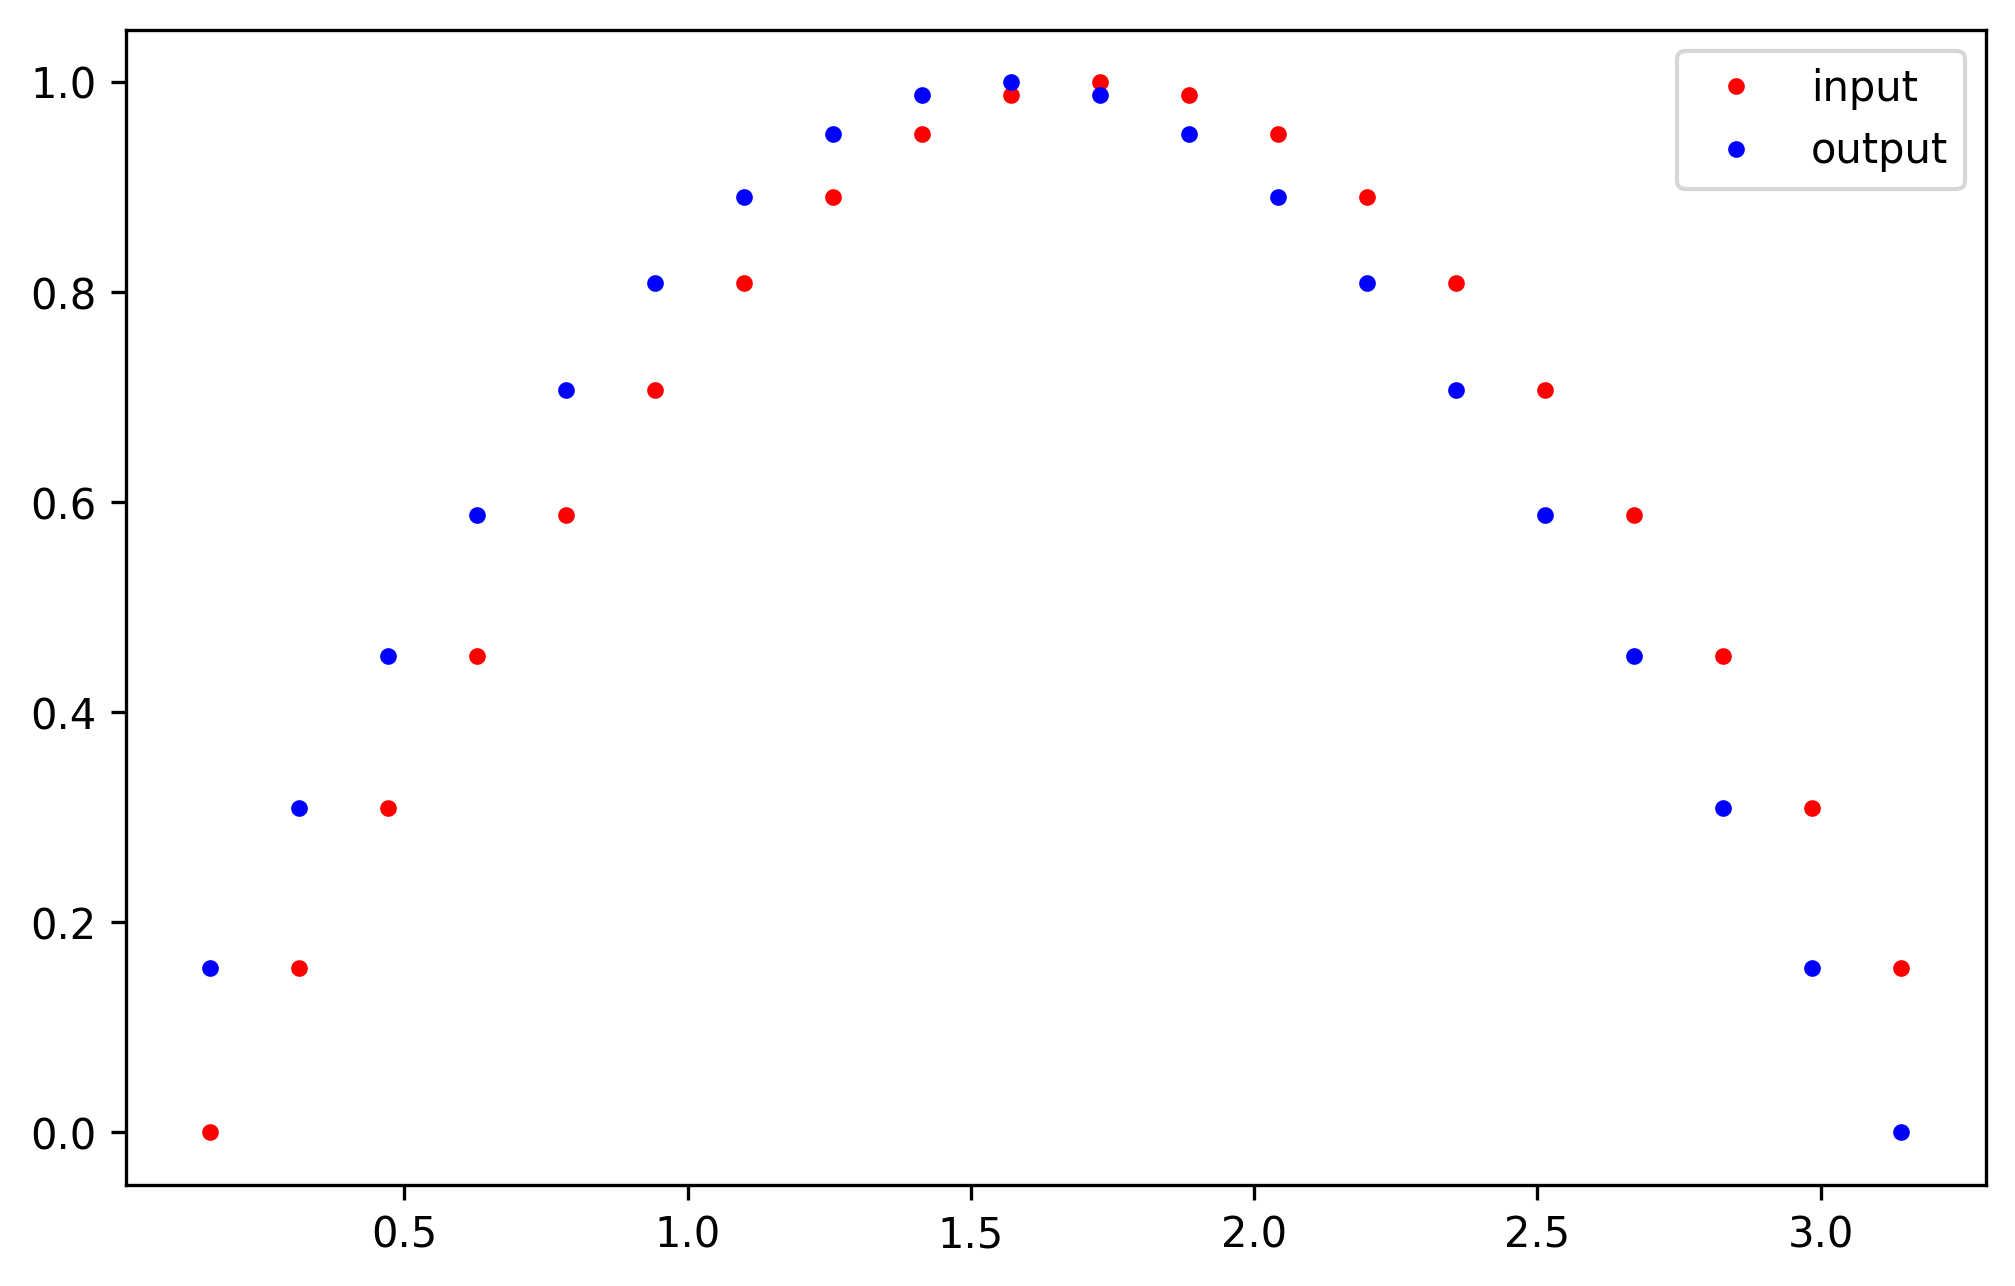

In [44]:
plt.figure(figsize=(8,5),dpi=300)
plt.plot(time_steps[1:], x, 'r.', label = 'input')
plt.plot(time_steps[1:], y, 'b.', label = 'output')
plt.legend(loc='best')
plt.show()

## Define the RNN

* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

In [45]:
class RNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x, hidden):
        batch_size=x.size(0)
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)
        output = self.fc(r_out)
        return output, hidden
        

In [56]:
# test that dimensions are as expected
test_rnn = RNN(input_dim=1, output_dim=1, hidden_dim=10, n_layers=2)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

print(data.shape)
# test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
test_input = torch.Tensor(data[np.newaxis, :]) # give it a batch_size of 1 as first dimension

print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

(20, 1)
Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


# Train RNN

In [33]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [34]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            # plt.plot(time_steps[1:], x, 'r.') # input
            # plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            # plt.show()
    
    return rnn


# Simple RNN by ChatGPT

In [35]:
import torch
import torch.nn as nn
import numpy as np

# Generate synthetic data
t = np.arange(0, 1000)
data = np.sin(2*np.pi*t*0.1) + np.random.randn(1000)*0.1

# Split the data into training and test sets
train_data = data[:800]
test_data = data[800:]
data.shape, test_data.shape, train_data.shape

((1000,), (200,), (800,))

In [71]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[0, :, :])
        return out, hidden

In [72]:
# Set hyperparameters
input_size = 1
hidden_size = 32
output_size = 1
learning_rate = 0.01
num_epochs = 100

# Instantiate the model and the loss function
model = RNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [73]:
hidden = torch.zeros(1, 1, hidden_size) # d*nums_layers, N, output_size
print(hidden.shape)

inputs = torch.from_numpy(train_data[np.newaxis, :-1, np.newaxis]).float()

targets = torch.from_numpy(train_data[1:, np.newaxis]).float()
print(targets.shape)

outputs, hidden = model(inputs, hidden)
outputs.shape, hidden.shape

torch.Size([1, 1, 32])
torch.Size([799, 1])


(torch.Size([799, 1]), torch.Size([1, 1, 32]))

In [74]:
# Train the model
for epoch in range(num_epochs):
    # Set the initial hidden state
    hidden = torch.zeros(1, 1, hidden_size)
    
    # Convert the data to tensors
    inputs = torch.from_numpy(train_data[np.newaxis, :-1, np.newaxis]).float()
    targets = torch.from_numpy(train_data[1:, np.newaxis]).float()
    
    # Forward pass
    outputs, hidden = model(inputs, hidden)
    loss = criterion(outputs, targets)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Evaluate the model on the test set
with torch.no_grad():
    # Set the initial hidden state
#     hidden = torch.zeros(1, len(test_data), hidden_size)
    
    # Convert the data to tensors
    inputs = torch.from_numpy(test_data[np.newaxis, :-1, np.newaxis]).float()
    targets = torch.from_numpy(test_data[1:, np.newaxis]).float()
    
    # Forward pass
    outputs, hidden = model(inputs, hidden)
    loss = criterion(outputs, targets)
    
    # Print the loss
    print('Test Loss: {:.4f}'.format(loss.item()))


Epoch [10/100], Loss: 0.0283
Epoch [20/100], Loss: 0.0153
Epoch [30/100], Loss: 0.0174
Epoch [40/100], Loss: 0.0151
Epoch [50/100], Loss: 0.0138
Epoch [60/100], Loss: 0.0134
Epoch [70/100], Loss: 0.0130
Epoch [80/100], Loss: 0.0128
Epoch [90/100], Loss: 0.0127
Epoch [100/100], Loss: 0.0125
Test Loss: 0.0135


In [95]:
inputs = torch.from_numpy(test_data[np.newaxis, :-1, np.newaxis]).float()
outputs, _ = model(inputs, None)
t.shape, outputs.shape

((200,), torch.Size([199, 1]))

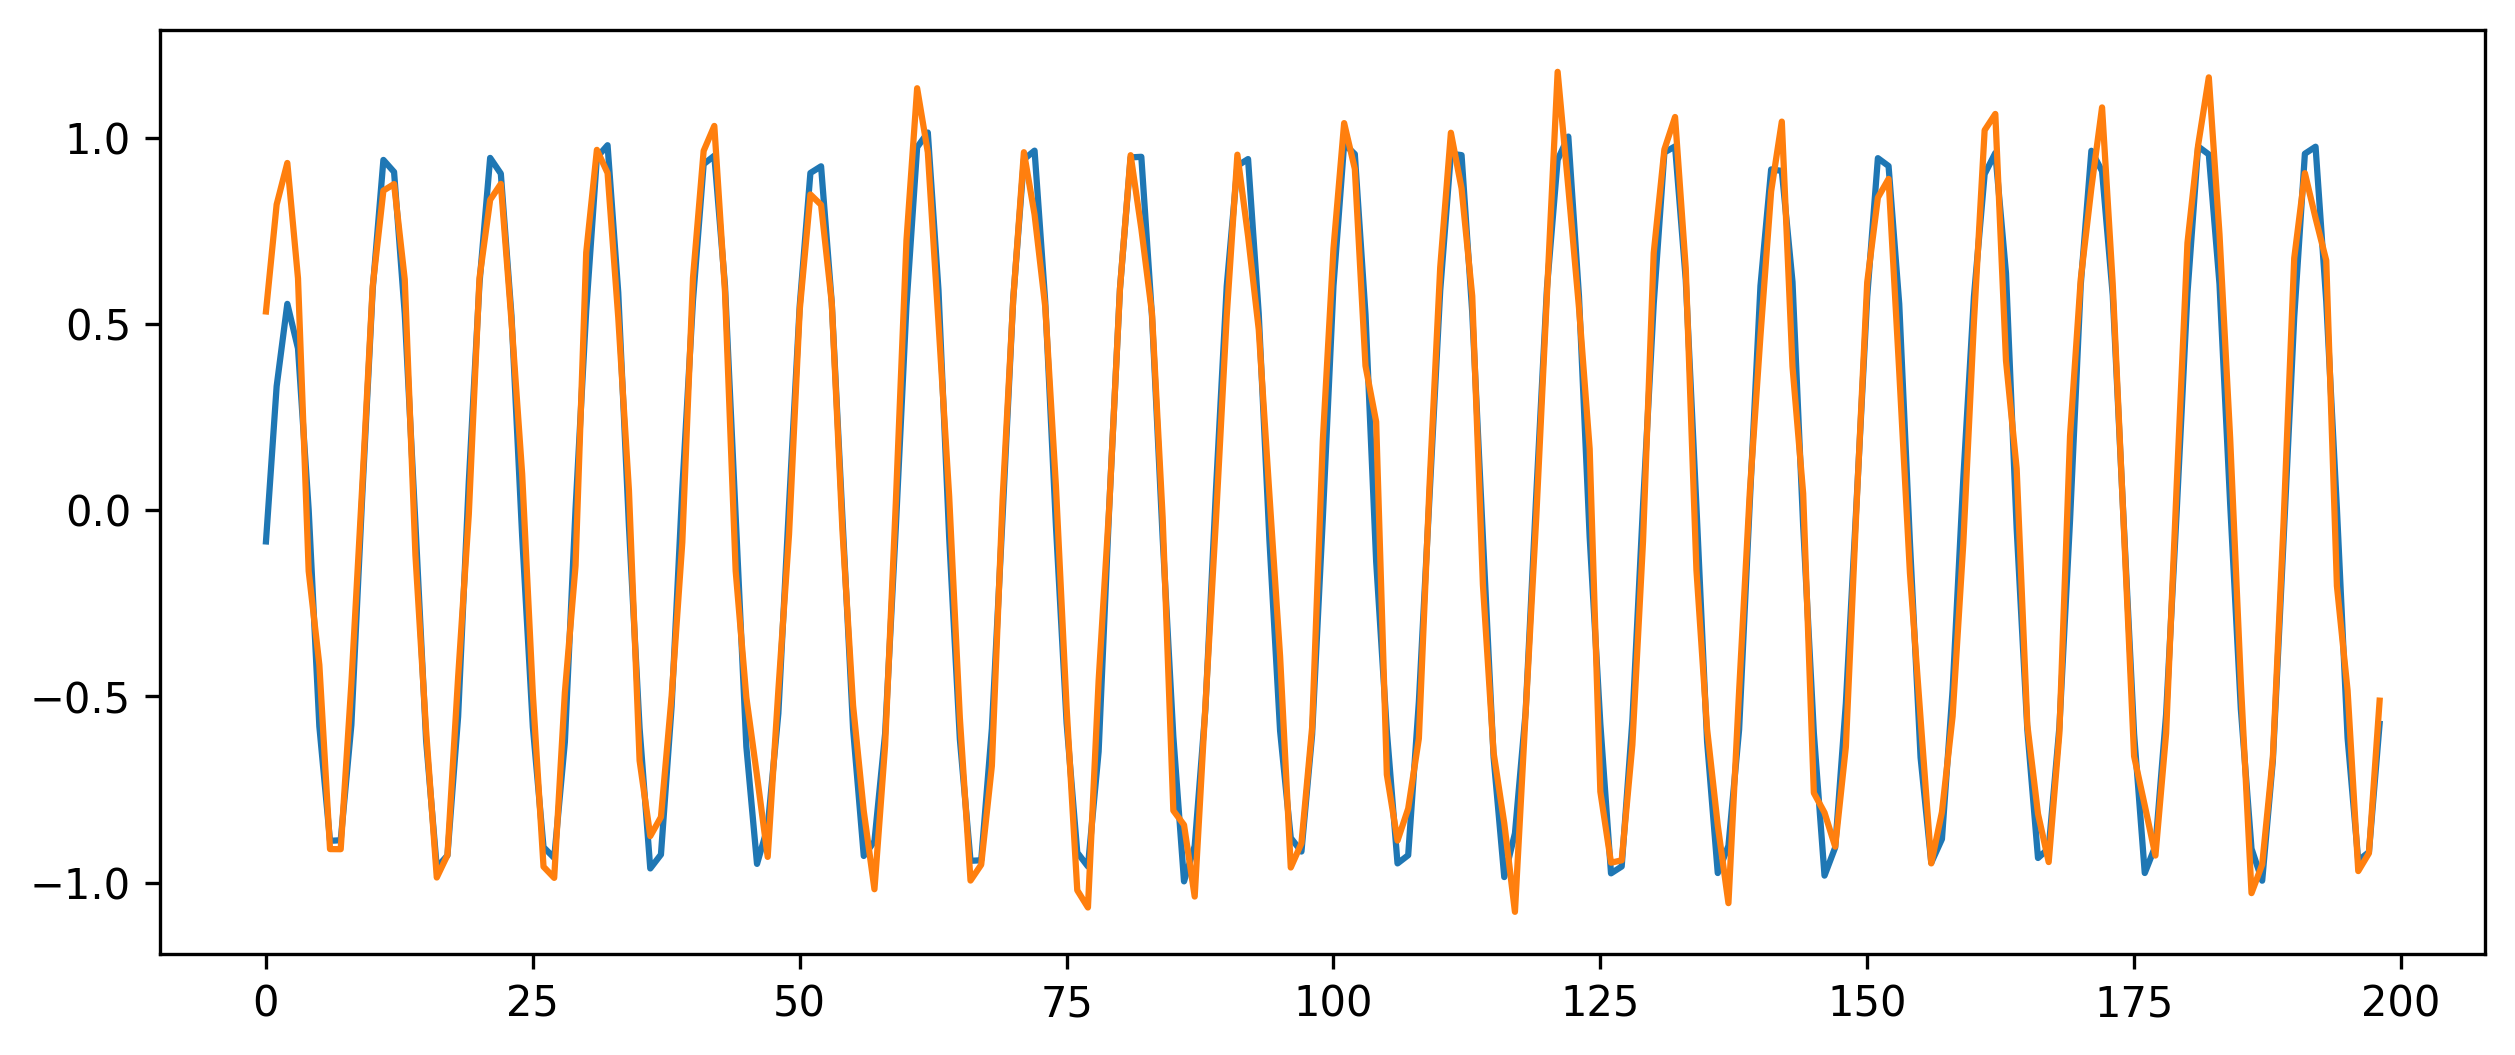

In [97]:
plt.figure(figsize=(10,4), dpi=300)
plt.plot(range(len(outputs)), outputs.detach().numpy())
plt.plot(range(len(outputs)), test_data[1:])